In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

In [2]:
#read image
img = cv2.imread('/content/colors.jpg')

In [3]:
#convert from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
#get rgb values from image to 1D array
r, g, b = cv2.split(img)
r = r.flatten()
g = g.flatten()
b = b.flatten()

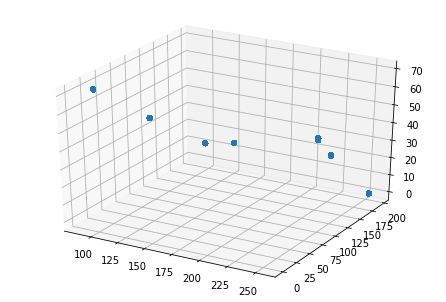

In [5]:
#plotting 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
plt.show()

In [20]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class DominantColors:

    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None
    
    def __init__(self, image, clusters=3):
        self.CLUSTERS = clusters
        self.IMAGE = image
        
    def dominantColors(self):
    
        #read image
        img = cv2.imread(self.IMAGE)
        
        #convert to rgb from bgr
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
        #reshaping to a list of pixels
        img = img.reshape((img.shape[0] * img.shape[1], 3))
        
        #save image after operations
        self.IMAGE = img
        
        #using k-means to cluster pixels
        kmeans = KMeans(n_clusters = self.CLUSTERS)
        kmeans.fit(img)
        
        #the cluster centers are our dominant colors.
        self.COLORS = kmeans.cluster_centers_
        
        #save labels
        self.LABELS = kmeans.labels_
        
        #returning after converting to integer from float
        return self.COLORS.astype(int)
    def rgb_to_hex(self, rgb):
        return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))
    
    def plotClusters(self):
        #plotting 
        fig = plt.figure()
        ax = Axes3D(fig)        
        for label, pix in zip(self.LABELS, self.IMAGE):
            ax.scatter(pix[0], pix[1], pix[2], color = self.rgb_to_hex(self.COLORS[label]))
        plt.show()

    def plotHistogram(self):
       
        #labels form 0 to no. of clusters
        numLabels = np.arange(0, self.CLUSTERS+1)
       
        #create frequency count tables    
        (hist, _) = np.histogram(self.LABELS, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        
        #appending frequencies to cluster centers
        colors = self.COLORS
        
        #descending order sorting as per frequency count
        colors = colors[(-hist).argsort()]
        hist = hist[(-hist).argsort()] 
        
        #creating empty chart
        chart = np.zeros((50, 500, 3), np.uint8)
        start = 0
        
        #creating color rectangles
        for i in range(self.CLUSTERS):
            end = start + hist[i] * 500
            
            #getting rgb values
            r = colors[i][0]
            g = colors[i][1]
            b = colors[i][2]
            
            #using cv2.rectangle to plot colors
            cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
            start = end	
        
        #display chart
        plt.figure()
        plt.axis("off")
        plt.imshow(chart)
        plt.show()


img = 'colors.jpg'
clusters = 5
dc = DominantColors(img, clusters) 
colors = dc.dominantColors()
print(colors)

[[144  12  61]
 [255 195   0]
 [255  87  50]
 [ 87  23  69]
 [199   0  56]]


In [ ]:
img = '/content/colors.jpg'
clusters = 5
dc = DominantColors(img, clusters)
colors = dc.dominantColors()
dc.plotClusters()

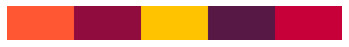

In [21]:
img = '/content/colors.jpg'
clusters = 5
dc = DominantColors(img, clusters)
colors = dc.dominantColors()
dc.plotHistogram()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

class KMeans():

    def __init__(self, K=5, max_iters=100, plot_steps=False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps

        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # the centers (mean feature vector) for each cluster
        self.centroids = []

    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        
        # initialize 
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]

        # Optimize clusters
        for _ in range(self.max_iters):
            # Assign samples to closest centroids (create clusters)
            self.clusters = self._create_clusters(self.centroids)
            if self.plot_steps:
                self.plot()

            # Calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)
            
            # check if clusters have changed
            if self._is_converged(centroids_old, self.centroids):
                break

            if self.plot_steps:
                self.plot()

        # Classify samples as the index of their clusters
        return self._get_cluster_labels(self.clusters)


    def _get_cluster_labels(self, clusters):
        # each sample will get the label of the cluster it was assigned to
        labels = np.empty(self.n_samples)

        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_idx
        return labels

    def _create_clusters(self, centroids):
        # Assign the samples to the closest centroids to create clusters
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _closest_centroid(self, sample, centroids):
        # distance of the current sample to each centroid
        distances = [euclidean_distance(sample, point) for point in centroids]
        closest_index = np.argmin(distances)
        return closest_index

    def _get_centroids(self, clusters):
        # assign mean value of clusters to centroids
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _is_converged(self, centroids_old, centroids):
        # distances between each old and new centroids, fol all centroids
        distances = [euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0

    def plot(self):
        fig, ax = plt.subplots(figsize=(12, 8))

        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)

        for point in self.centroids:
            ax.scatter(*point, marker="x", color='black', linewidth=2)

        plt.show()
    def cent(self):
        return self.centroids